## Importing libraries

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Loading the data set

The data set is assigned to a Pandas data frame.

In [21]:
new_df = pd.read_csv('data/new_df.csv', index_col=0, decimal='.')

# CLUSTERING

## Clustering Preprocessing - Normalization
First thing to do in clustering is to normalize data. We used `MinMaxScaler` to do this.

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_transformed = scaler.fit_transform(new_df.values)

## K-Means
Parameters:
* **K**: the number of clusters.

We exploited the Elbow method to find the best value for `K`, calculating the mean of SSE for each value from 1 to 20 clusters.

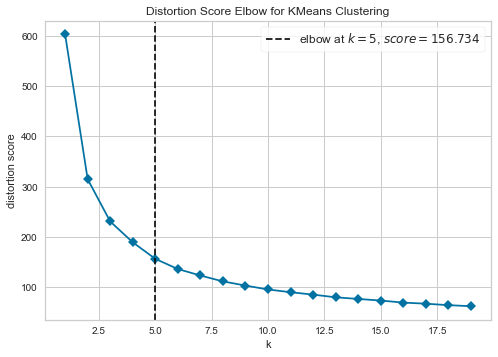

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
km = KMeans()
visualizer = KElbowVisualizer(
    km, k=(1,20), metric='distortion', timings=False)
visualizer.fit(df_transformed)
visualizer.show()

Then, we applied K-Means with the previously found value.

In [24]:
n_clusters = visualizer.elbow_value_
kmeans = KMeans(n_clusters=n_clusters, n_init=20, max_iter=100)
kmeans.fit(df_transformed)
hist, bins = np.histogram(kmeans.labels_,
                          bins=range(0, len(set(kmeans.labels_)) + 1))

This is the size of the retrieved clusters.

In [25]:
dict(zip(bins, hist))

{0: 1693, 1: 624, 2: 1177, 3: 461, 4: 216}

Visualization of cluster in two dimensions.

(`I` and `BasketNum`)

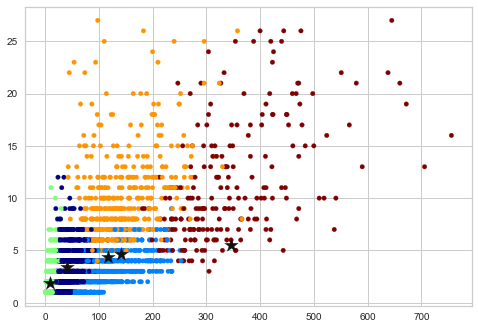

In [26]:
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.scatter(new_df['I'], new_df['BasketNum'], c=kmeans.labels_, s=20, cmap=plt.cm.get_cmap('jet'))
plt.scatter(centers[:, 0], centers[:, 3], s=200, marker='*', c='k')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

Visualization of cluster in three dimensions.

(`I`, `BasketNum`, and `SumExp`)

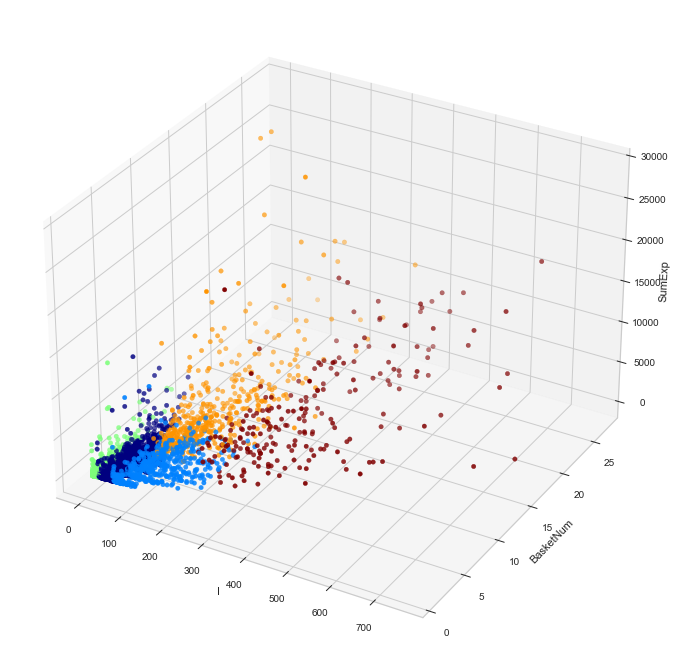

In [27]:
fig = plt.figure(figsize=(16,12))
ax2 = fig.gca(projection='3d')
ax2.scatter(new_df['I'],
           new_df['BasketNum'],
           new_df['SumExp'],
           c=kmeans.labels_, marker='o', cmap=plt.cm.get_cmap('jet'))
ax2.set_xlabel('I')
ax2.set_ylabel('BasketNum')
ax2.set_zlabel('SumExp')
plt.show()

*Parallel coordinates* to find patterns in our dataset.

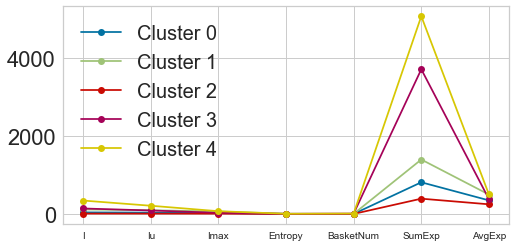

In [28]:
plt.figure(figsize=(8, 4))
for i in range(0, len(centers)):
    plt.plot(centers[i], marker='o', label='Cluster %s' % i)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks(range(0, len(new_df.columns)), new_df.columns, fontsize=10)
plt.legend(fontsize=20)
plt.show()

## DBSCAN

Parameters:
* **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
* **min_samples**: The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself.

`min_samples` was set to twice the dimension of our dataset.

In [29]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator

min_pts = new_df.shape[1] * 2

Also for `DBSCAN` we exploited the Elbow/Knee Method,
to find the best value for `eps`

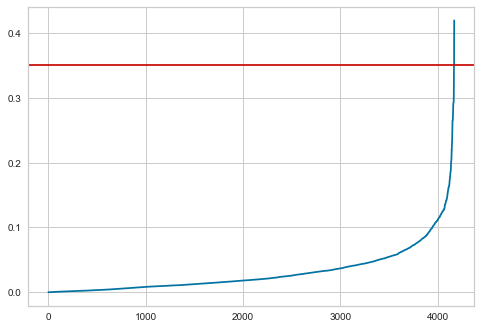

In [30]:
neighbors = NearestNeighbors(n_neighbors=min_pts)
neighbors_fit = neighbors.fit(df_transformed)
distances, indices = neighbors_fit.kneighbors(df_transformed)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
kneedle = KneeLocator(range(distances.shape[0]), distances, S=1.0, curve="convex", direction="increasing")
plt.plot(range(distances.shape[0]), distances)
eps = kneedle.knee_y
plt.axhline(y=eps, color='r', linestyle='-', label="eps")
plt.show()

We applied `DBSCAN` with different parameter values.
Here we reported the run with the values found with Knee Method.

In [31]:
dbscan = DBSCAN(eps=eps, min_samples=min_pts)
dbscan.fit(df_transformed)

DBSCAN(eps=0.35098101261991493, min_samples=14)

In [32]:
labels, counts = np.unique(dbscan.labels_, return_counts=True)
print(labels, counts)

[-1  0] [  15 4156]


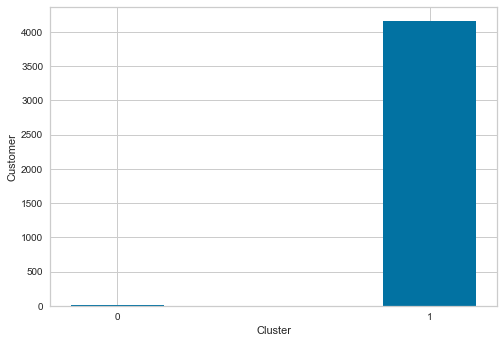

In [33]:
plt.bar(x=range(len(counts)), height=counts, width=0.3)
plt.xticks(np.arange(2))
plt.xlabel("Cluster")
plt.ylabel("Customer")
plt.show()


## Hierarchical Clustering

In [34]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# auxiliary funciton to generate dendrogram with
# given method and metric
def hierarchical(method, metric):
    data_dist = pdist(df_transformed, metric=metric)
    data_link = linkage(data_dist, method=method, metric=metric)
    dendrogram(data_link, truncate_mode='lastp')

    max_d = 0.7*max(data_link[:,2])
    app = fcluster(data_link, max_d, criterion='distance')
    print(np.unique(app, return_counts=True))

Some examples of `hierarchical` function application.

(array([1, 2, 3, 4], dtype=int32), array([   2, 4167,    1,    1]))


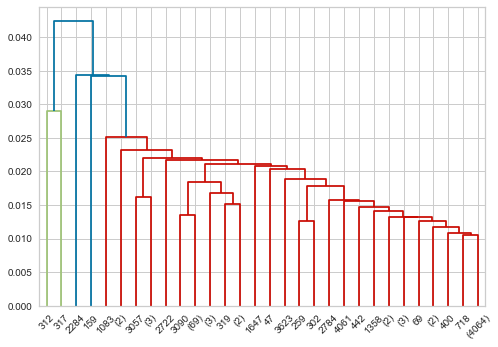

In [35]:
hierarchical(method='single', metric='cosine')

(array([1, 2, 3, 4], dtype=int32), array([  74, 1081,  126, 2890]))


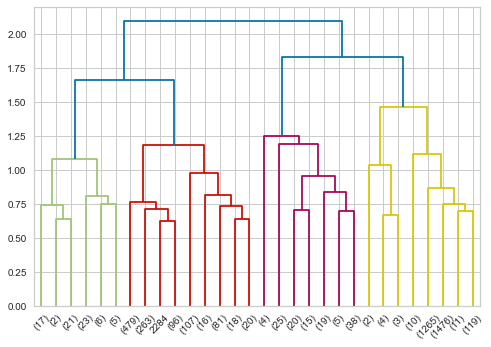

In [36]:
hierarchical(method='complete', metric='euclidean')

(array([1, 2, 3, 4], dtype=int32), array([ 155, 4008,    3,    5]))


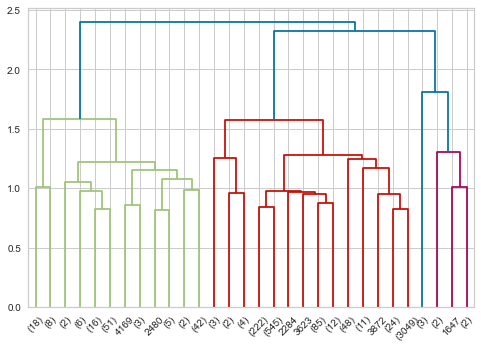

In [37]:
hierarchical(method='average', metric='cityblock')

(array([1, 2], dtype=int32), array([  76, 4095]))


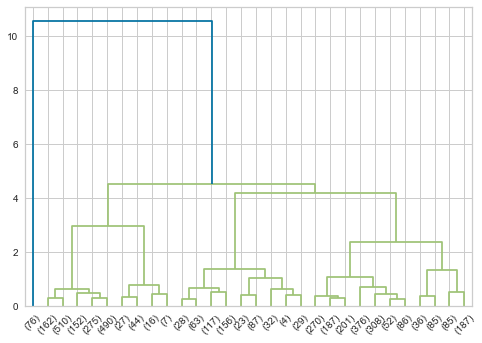

In [38]:
hierarchical(method='ward', metric='cosine')
